In [2]:
from src.efficient_kan import KAN

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm

In [4]:
import numpy as np
import random

In [5]:
config = {}
config['input_dim'] = 128
config['batch_size'] = 64
config['hidden_layers'] = [64, 5]
config['lr'] = 1e-3



In [6]:
class kae_dataset(Dataset):
    def __init__(self, num_data=100, input_dim=128):
        super(kae_dataset, self).__init__()
        self.num_data = num_data
        self.target = []
        for i in range(num_data):
            scale = random.random()
            phase_left = random.random() + 0.1
            phase_right = random.random() + 0.1
            x=np.arange(-phase_left*2*np.pi,phase_right*2*np.pi,(phase_right*2*np.pi+phase_left*2*np.pi)/input_dim)
            x=x.reshape(len(x),1)
            y=scale * np.sin(x)
            self.target.append(y)

    def __getitem__(self, index):
        target = torch.from_numpy(self.target[index]).squeeze().unsqueeze(0).to(torch.float32)
        return target

    def __len__(self):
        return len(self.target)

trainset = kae_dataset(10000, config['input_dim'])
valset = kae_dataset(100, config['input_dim'])
trainloader = DataLoader(trainset, batch_size=config['batch_size'], shuffle=True)
valloader = DataLoader(valset, batch_size=config['batch_size'], shuffle=False)

In [7]:
class KAE(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        input_dim,
    ):
        super(KAE, self).__init__()
        self.encoder = KAN([input_dim, layers_hidden[0], layers_hidden[1]])
        self.decoder = KAN([layers_hidden[1], layers_hidden[0], input_dim])

    def forward(self, x: torch.Tensor):
        x = self.decoder(self.encoder(x))
        return x

In [8]:
# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KAE(layers_hidden=config['hidden_layers'], input_dim=config['input_dim'])
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define loss
criterion = nn.MSELoss()

In [9]:
for epoch in range(10):
    # Train
    model.train()
    with tqdm(trainloader) as pbar:
        for i, targets in enumerate(pbar):
            targets = targets.view(-1, config['input_dim']).to(device)
            optimizer.zero_grad()
            output = model(targets)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for targets in valloader:
            targets = targets.view(-1, config['input_dim']).to(device)
            output = model(targets)
            val_loss += criterion(output, targets).item()
            
    val_loss /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}"
    )

100%|██████████| 157/157 [00:08<00:00, 19.20it/s, loss=0.00798, lr=0.001]


Epoch 1, Val Loss: 0.0089034428820014


100%|██████████| 157/157 [00:03<00:00, 44.98it/s, loss=0.000692, lr=0.0008]


Epoch 2, Val Loss: 0.0015588562819175422


100%|██████████| 157/157 [00:03<00:00, 46.02it/s, loss=0.000563, lr=0.00064]


Epoch 3, Val Loss: 0.0006006945914123207


100%|██████████| 157/157 [00:03<00:00, 44.73it/s, loss=0.000111, lr=0.000512]


Epoch 4, Val Loss: 0.00031740032136440277


100%|██████████| 157/157 [00:03<00:00, 44.99it/s, loss=0.000355, lr=0.00041]


Epoch 5, Val Loss: 0.00021486396144609898


100%|██████████| 157/157 [00:03<00:00, 46.28it/s, loss=6.48e-5, lr=0.000328] 


Epoch 6, Val Loss: 0.00017441317322663963


100%|██████████| 157/157 [00:03<00:00, 47.20it/s, loss=0.000114, lr=0.000262]


Epoch 7, Val Loss: 0.00014246571299736388


100%|██████████| 157/157 [00:03<00:00, 44.15it/s, loss=0.000115, lr=0.00021]


Epoch 8, Val Loss: 0.00012435036478564143


100%|██████████| 157/157 [00:03<00:00, 45.10it/s, loss=7.9e-5, lr=0.000168]  


Epoch 9, Val Loss: 0.00011276353689027019


100%|██████████| 157/157 [00:03<00:00, 42.75it/s, loss=4.08e-5, lr=0.000134] 


Epoch 10, Val Loss: 0.00010661395572242327


In [62]:
pred = model(valset[0].to(device)).detach().cpu().numpy()[0]

In [13]:
import matplotlib.pyplot as plt

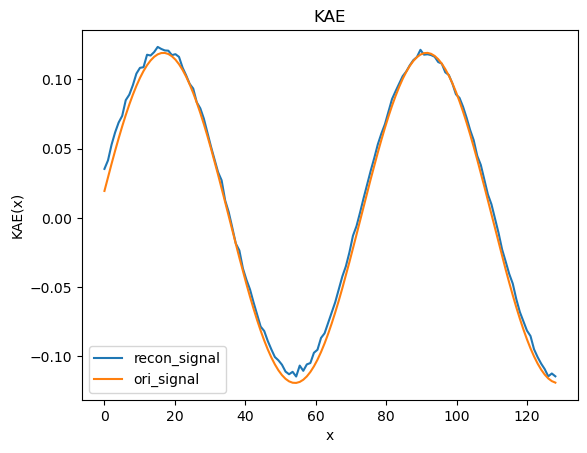

In [66]:
x = np.linspace(0, config['input_dim'], config['input_dim'])
plt.plot(x, pred, label='recon_signal')
plt.plot(x, valset[0][0], label='ori_signal')
plt.xlabel('x')
plt.ylabel('KAE(x)')
plt.title('KAE')
plt.legend()
plt.savefig('assets/recon_signal.jpg')
plt.show()

In [57]:
mix_latent = model.encoder(valset[0].to(device))/2 + model.encoder(valset[2].to(device))/2
mixed_signal = model.decoder(mix_latent).detach().cpu().numpy()[0]
signal0 = model(valset[0].to(device)).detach().cpu().numpy()[0]
signal1 = model(valset[2].to(device)).detach().cpu().numpy()[0]

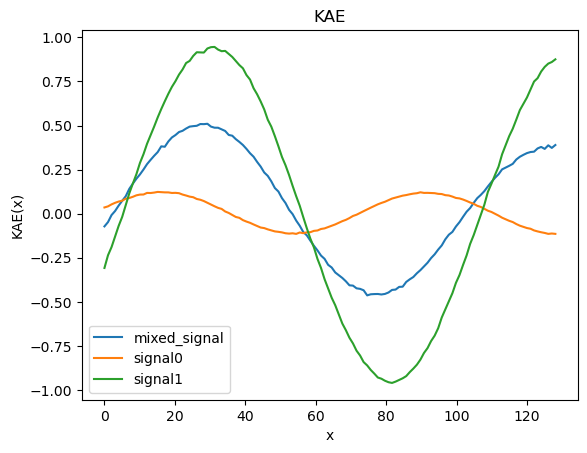

In [67]:
x = np.linspace(0, config['input_dim'], config['input_dim'])
plt.plot(x, mixed_signal, label='mixed_signal')
plt.plot(x, signal0, label='signal0')
plt.plot(x, signal1, label='signal1')
plt.xlabel('x')
plt.ylabel('KAE(x)')
plt.title('KAE')
plt.legend()
plt.savefig('assets/mix_signal.jpg')
plt.show()